<a href="https://colab.research.google.com/github/mayankmnitj/HHO-CNN-BiLSTM/blob/main/Share_Final_code_for_HHO_on_McIntire_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy tensorflow scikit-learn openpyxl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Harris Hawks Optimization (HHO) implementation
def hho(fobj, lb, ub, dim, SearchAgents_no, Max_iter):
    # Initialize the positions of search agents
    Positions = np.random.uniform(0, 1, (SearchAgents_no, dim)) * (ub - lb) + lb
    Convergence_curve = np.zeros(Max_iter)

    # Initialize the best solution
    best_pos = Positions[0, :].copy()  # Initialize with first agent's position
    best_fitness = float('inf')  # Initialize with a high value

    # Main loop
    for t in range(Max_iter):
        for i in range(SearchAgents_no):
            # Fitness calculation
            fitness = fobj(Positions[i, :])

            # Update the best solution
            if fitness < best_fitness:  # Correct condition
                best_fitness = fitness
                best_pos = Positions[i, :].copy()

        Convergence_curve[t] = best_fitness  # Store best fitness

        # Update the positions of search agents
        E1 = 2 * (1 - t / Max_iter)
        for i in range(SearchAgents_no):
            E0 = 2 * np.random.rand() - 1
            E = E1 * E0

            if abs(E) >= 1:
                # Exploration phase
                q = np.random.rand()
                if q >= 0.5:
                    Positions[i, :] = np.random.uniform(0, 1, dim) * (ub - lb) + lb
                else:
                    r = np.random.rand(dim)
                    Positions[i, :] = (best_pos - np.mean(Positions, axis=0)) - r * (lb + r * (ub - lb))
            else:
                # Exploitation phase
                r = np.random.rand(dim)
                if abs(E) >= 0.5:
                    Positions[i, :] = best_pos - E * abs(best_pos - Positions[i, :])
                else:
                    Positions[i, :] = best_pos - E * abs(best_pos - Positions[i, :]) * r

    return best_pos, Convergence_curve

# Objective function
def objective_function(features):
    selected_features = [i for i, val in enumerate(features) if val > 0.5]
    if len(selected_features) == 0:
        return float('inf')

    X_selected = X.iloc[:, selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return 1 - accuracy_score(y_test, y_pred)

# Load the dataset
data = pd.read_excel('/content/drive/MyDrive/Ph.D/arrays_Mcintire.xlsx')

# Separate features and target
X = data.drop(columns=['label'])
y = data['label']

# Normalize the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Define the parameters for HHO
dim = X.shape[1]  # Number of features
lb = 0  # Lower bound for feature selection
ub = 1  # Upper bound for feature selection
SearchAgents_no = 10  # Number of search agents
Max_iter = 20  # Maximum number of iterations

# Run HHO
best_features, convergence_curve = hho(objective_function, lb, ub, dim, SearchAgents_no, Max_iter)

# Get the selected features
selected_features = [i for i, val in enumerate(best_features) if val > 0.5]
print("Selected Features:", selected_features)

# Evaluate the model with selected features
X_selected = X.iloc[:, selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)

Selected Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 73, 74, 76, 77, 79]
Accuracy with selected features: 0.9163598106259864


In [3]:
len(selected_features)

68

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec

In [5]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Load dataset
data = pd.read_csv(r'/content/drive/MyDrive/Ph.D/Mcintire_DataSet.csv', header=0)
data=data[['text','label']].dropna()
# Initialize stopwords & lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase text
    text = text.lower()

    # Remove URLs & Email Addresses
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords & apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing
data['clean_text'] = data['text'].astype(str).apply(preprocess_text)

# Tokenize sentences into word lists
tokenized_sentences = [sentence.split() for sentence in data['clean_text'].tolist()]

# Display sample
print(data[['text', 'clean_text']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  \
0  Daniel Greenfield, a Shillman Journalism Fello...   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...   
2  U.S. Secretary of State John F. Kerry said Mon...   
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...   
4  It's primary day in New York and front-runners...   

                                          clean_text  
0  daniel greenfield shillman journalism fellow f...  
1  google pinterest digg linkedin reddit stumbleu...  
2  u secretary state john f kerry said monday sto...  
3  kaydee king november lesson tonight dem loss t...  
4  primary day new york frontrunners hillary clin...  


In [6]:
## Step 3: Generate Word Embeddings
# =============================
#data = pd.read_csv(r'/content/drive/MyDrive/Ph.D/Mcintire_DataSet.csv', header=0)
#text_data = data['text'].astype(str).tolist()  # Convert to list of strings
#tokenized_sentences = [sentence.split() for sentence in text_data]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Generate word embeddings for each text entry
word_embeddings = np.array([
    np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
    for sentence in tokenized_sentences
])

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 459ms/step - accuracy: 0.6302 - loss: 0.6437 - val_accuracy: 0.7975 - val_loss: 0.4484
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 50s 358ms/step - accuracy: 0.7887 - loss: 0.4384 - val_accuracy: 0.8217 - val_loss: 0.3869
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 338ms/step - accuracy: 0.8355 - loss: 0.3795 - val_accuracy: 0.8669 - val_loss: 0.3343
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 52s 378ms/step - accuracy: 0.8552 - loss: 0.3241 - val_accuracy: 0.8864 - val_loss: 0.2811
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 358ms/step - accuracy: 0.8747 - loss: 0.2924 - val_accuracy: 0.8911 - val_loss: 0.2794
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 335ms/step - accuracy: 0.8874 - loss: 0.2606 - val_accuracy: 0.8680 - val_loss: 0.3159
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 318ms/step - accuracy: 0.8703 - loss: 0.2912 - val_accuracy: 0.8822 - val_loss: 0.2849
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 86s 351ms/step - accuracy: 0.9025 - loss: 0

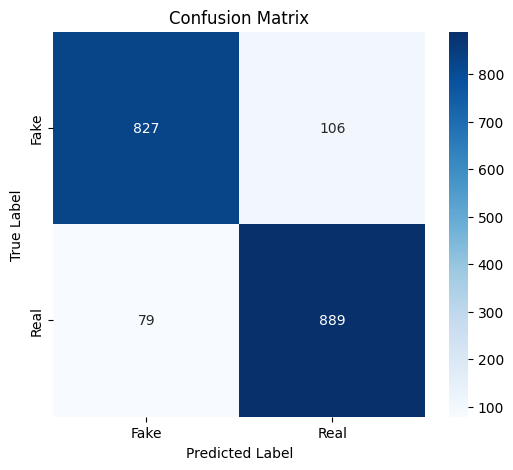

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# =============================
# Step 4: Concatenate Features and Embeddings
# =============================
X_combined = np.concatenate((X_selected, word_embeddings), axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# =============================
# Step 5: Define CNN-BiLSTM Model
# =============================

input_layer = Input(shape=(X_train.shape[1], 1))

# Parallel CNN layers
cnn1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn2 = Conv1D(filters=128, kernel_size=4, activation='relu', padding='same')(input_layer)
cnn3 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(input_layer)

# Max pooling
pool1 = MaxPooling1D(pool_size=2)(cnn1)
pool2 = MaxPooling1D(pool_size=2)(cnn2)
pool3 = MaxPooling1D(pool_size=2)(cnn3)

# Merge CNN outputs
merged_cnn = Concatenate()([pool1, pool2, pool3])

# BiLSTM Layer
bilstm = Bidirectional(LSTM(64, return_sequences=False))(merged_cnn)

# Dropout for regularization
dropout = Dropout(0.3)(bilstm)

# Fully connected output layer
output_layer = Dense(1, activation='sigmoid')(dropout)

# Define model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# =============================
# Step 6: Train CNN-BiLSTM Model
# =============================
X_train = np.expand_dims(X_train, axis=-1)  # Reshape for Conv1D input
X_test = np.expand_dims(X_test, axis=-1)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Final CNN-BiLSTM Model Accuracy:", accuracy)

# =============================
# Step 7: Confusion Matrix Visualization
# =============================

# Generate Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



Training K-Nearest Neighbors (KNN)...
K-Nearest Neighbors (KNN) Accuracy: 0.8848
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       933
           1       0.88      0.89      0.89       968

    accuracy                           0.88      1901
   macro avg       0.88      0.88      0.88      1901
weighted avg       0.88      0.88      0.88      1901



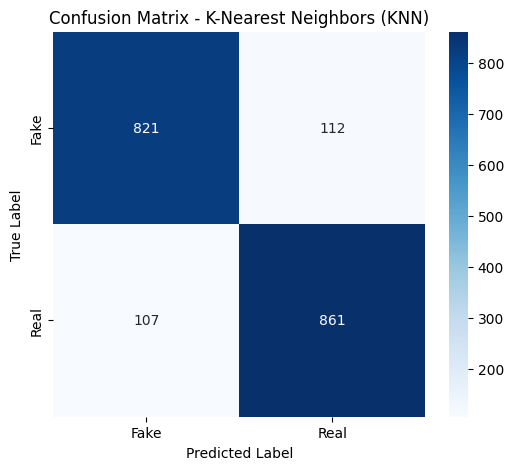


Training Random Forest (RF)...
Random Forest (RF) Accuracy: 0.9248
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       933
           1       0.92      0.93      0.93       968

    accuracy                           0.92      1901
   macro avg       0.92      0.92      0.92      1901
weighted avg       0.92      0.92      0.92      1901



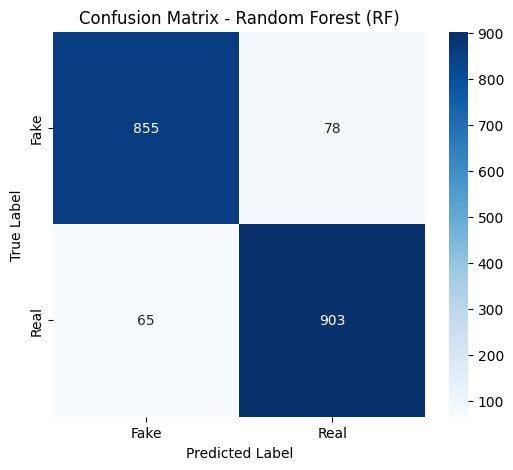


Training AdaBoost...
AdaBoost Accuracy: 0.9306
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       933
           1       0.93      0.93      0.93       968

    accuracy                           0.93      1901
   macro avg       0.93      0.93      0.93      1901
weighted avg       0.93      0.93      0.93      1901



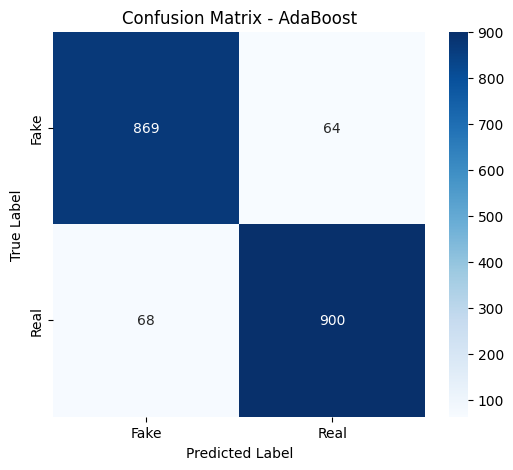


Training Bagging...
Bagging Accuracy: 0.9211
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       933
           1       0.92      0.92      0.92       968

    accuracy                           0.92      1901
   macro avg       0.92      0.92      0.92      1901
weighted avg       0.92      0.92      0.92      1901



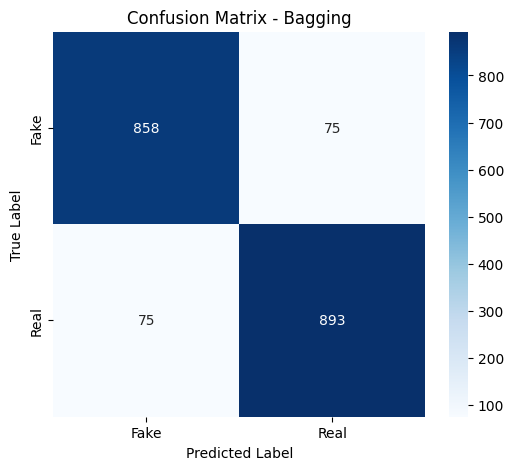


Training Gaussian Naive Bayes (GNB)...
Gaussian Naive Bayes (GNB) Accuracy: 0.8259
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       933
           1       0.89      0.75      0.82       968

    accuracy                           0.83      1901
   macro avg       0.83      0.83      0.83      1901
weighted avg       0.83      0.83      0.83      1901



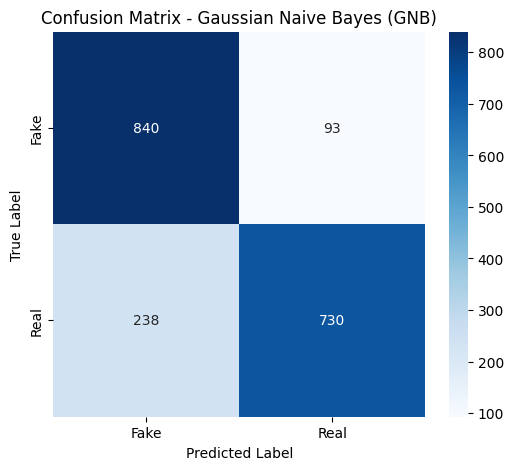


Training Support Vector Machine (SVM)...
Support Vector Machine (SVM) Accuracy: 0.9337
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       933
           1       0.93      0.93      0.93       968

    accuracy                           0.93      1901
   macro avg       0.93      0.93      0.93      1901
weighted avg       0.93      0.93      0.93      1901



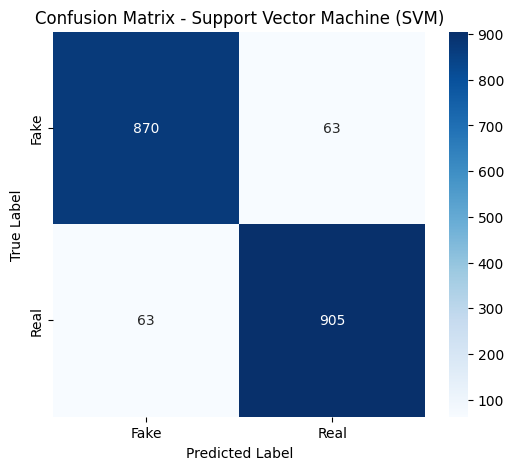

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# =============================
# Step 1: Prepare Data
# =============================
X_combined = np.concatenate((X_selected, word_embeddings), axis=1)  # Combine features and embeddings
y = np.array(y)  # Convert target variable to NumPy array

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# =============================
# Step 2: Define ML Models
# =============================

models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest (RF)": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Bagging": BaggingClassifier(n_estimators=100, random_state=42),
    "Gaussian Naive Bayes (GNB)": GaussianNB(),
    "Support Vector Machine (SVM)": SVC(kernel='linear', probability=True, random_state=42)
}

# =============================
# Step 3: Train & Evaluate Each Model
# =============================

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print results
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # =============================
    # Step 4: Display Confusion Matrix
    # =============================
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


Logistic Regression Accuracy: 0.9353

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       933
           1       0.94      0.94      0.94       968

    accuracy                           0.94      1901
   macro avg       0.94      0.94      0.94      1901
weighted avg       0.94      0.94      0.94      1901



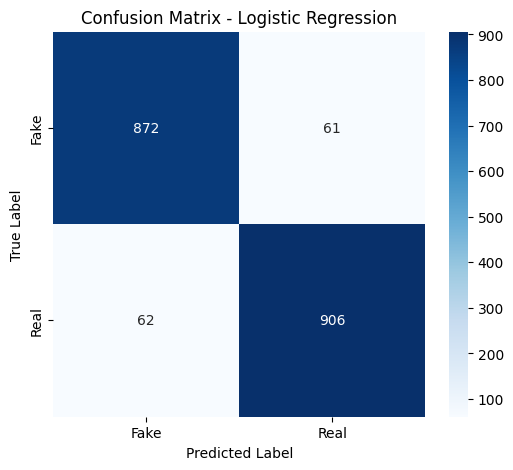

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# =============================
# Step 1: Prepare Data
# =============================

X_combined = np.concatenate((X_selected, word_embeddings), axis=1)  # Combine selected features and embeddings
y = np.array(y)  # Convert target variable to NumPy array

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# =============================
# Step 2: Train Logistic Regression Model
# =============================

log_reg = LogisticRegression(max_iter=500, solver='lbfgs', random_state=42)  # Define Logistic Regression model
log_reg.fit(X_train, y_train)  # Train model

# Predict on test data
y_pred = log_reg.predict(X_test)

# =============================
# Step 3: Evaluate Model Performance
# =============================

accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy
print(f"Logistic Regression Accuracy: {accuracy:.4f}")  # Print accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Print precision, recall, F1-score

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# =============================
# Step 4: Plot Confusion Matrix
# =============================

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7676 - loss: 0.4687 - val_accuracy: 0.8632 - val_loss: 0.3364
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8441 - loss: 0.3651 - val_accuracy: 0.8680 - val_loss: 0.3156
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8526 - loss: 0.3416 - val_accuracy: 0.8785 - val_loss: 0.2968
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8547 - loss: 0.3444 - val_accuracy: 0.8585 - val_loss: 0.3233
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8479 - loss: 0.3525 - val_accuracy: 0.8727 - val_loss: 0.2982
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8647 - loss: 0.3336 - val_accuracy: 0.8580 - val_loss: 0.3256
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8907 - loss: 0.2703
CNN Model Accuracy (Word Embeddings Only): 0.8785
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


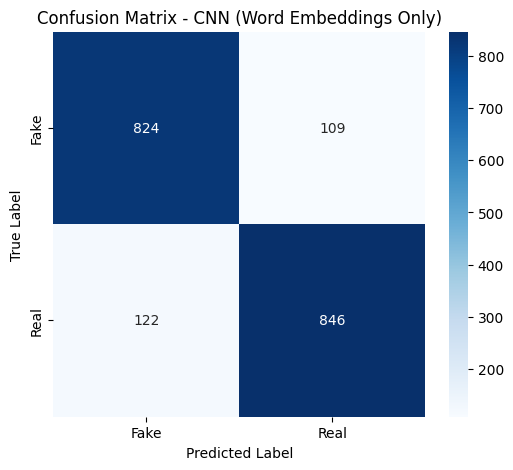

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# =============================
# Step 1: Prepare Data
# =============================

X_embeddings = np.array(word_embeddings)  # Use word embeddings only
y = np.array(y)  # Convert target variable to NumPy array

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.3, random_state=42)

# Reshape input for Conv1D
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# =============================
# Step 2: Define CNN Model
# =============================

input_layer = Input(shape=(X_train.shape[1], 1))  # Input layer

cnn = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_layer)  # CNN Layer
cnn = MaxPooling1D(pool_size=2)(cnn)  # Max pooling layer
cnn = Flatten()(cnn)  # Flatten output

dropout = Dropout(0.5)(cnn)  # Dropout for regularization
output_layer = Dense(1, activation='sigmoid')(dropout)  # Output layer

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# =============================
# Step 3: Train CNN Model
# =============================

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"CNN Model Accuracy (Word Embeddings Only): {accuracy:.4f}")

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# =============================
# Step 4: Compute Confusion Matrix
# =============================

conf_matrix = confusion_matrix(y_test, y_pred)

# =============================
# Step 5: Plot Confusion Matrix
# =============================

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN (Word Embeddings Only)")
plt.show()


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       933
           1       0.89      0.88      0.89       968

    accuracy                           0.88      1901
   macro avg       0.88      0.88      0.88      1901
weighted avg       0.88      0.88      0.88      1901



Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7847 - loss: 0.4538 - val_accuracy: 0.8569 - val_loss: 0.3340
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8561 - loss: 0.3286 - val_accuracy: 0.8727 - val_loss: 0.3045
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8593 - loss: 0.3352 - val_accuracy: 0.8832 - val_loss: 0.2829
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8644 - loss: 0.3108 - val_accuracy: 0.8690 - val_loss: 0.3066
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8617 - loss: 0.3170 - val_accuracy: 0.8648 - val_loss: 0.3101
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8814 - loss: 0.2858 - val_accuracy: 0.8801 - val_loss: 0.2875
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9012 - loss: 0.2562
LSTM Model Accuracy (Word Embeddings Only): 0.8832
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


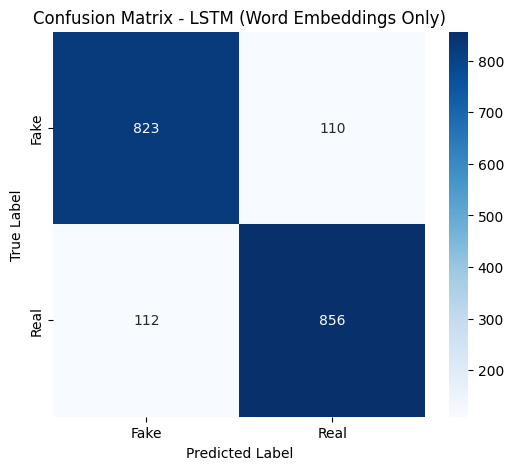

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# =============================
# Step 1: Prepare Data
# =============================

X_embeddings = np.array(word_embeddings)  # Use word embeddings only
y = np.array(y)  # Convert target variable to NumPy array

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.3, random_state=42)

# Reshape input for LSTM (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# =============================
# Step 2: Define LSTM Model
# =============================

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Input layer

lstm = LSTM(64, return_sequences=False)(input_layer)  # LSTM Layer
dropout = Dropout(0.5)(lstm)  # Dropout for regularization
output_layer = Dense(1, activation='sigmoid')(dropout)  # Output layer

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# =============================
# Step 3: Train LSTM Model
# =============================

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy (Word Embeddings Only): {accuracy:.4f}")

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# =============================
# Step 4: Compute Confusion Matrix
# =============================

conf_matrix = confusion_matrix(y_test, y_pred)

# =============================
# Step 5: Plot Confusion Matrix
# =============================

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM (Word Embeddings Only)")
plt.show()


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       933
           1       0.89      0.88      0.89       968

    accuracy                           0.88      1901
   macro avg       0.88      0.88      0.88      1901
weighted avg       0.88      0.88      0.88      1901

